In [1]:
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path
from tensorflow import keras
from livelossplot.inputs.keras import PlotLossesCallback
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle

In [2]:
batch_size = 2
#train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, 
#                                                       zoom_range=0.2, 
#                                                       horizontal_flip=True,
#                                                       fill_mode="nearest",
#                                                       rotation_range=25,
#                                                       preprocessing_function=preprocess_input)

train= tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2, rotation_range=90, 
                                                     width_shift_range=0.5, 
                                                     height_shift_range=0.5,
                                                     zoom_range=0.2,
                                                    horizontal_flip=True, 
                                                     vertical_flip=True,
                                                     preprocessing_function=preprocess_input)


test= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
traingen = train.flow_from_directory(directory="train",
                                        target_size=(224,224), 
                                        class_mode='categorical',
                                        shuffle= True,
                                        )

Found 6005 images belonging to 102 classes.


In [4]:
validgen = test.flow_from_directory(directory="val", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    shuffle= True,
                                    )

Found 1019 images belonging to 102 classes.


In [5]:
pic = load_img("image_00070.jpg")
pic_array = img_to_array(pic)
pic_array = pic_array.reshape((1, )+ pic_array.shape)
pic_array.shape

(1, 500, 667, 3)

count = 0
for batch in train.flow(pic_array, batch_size = 1, save_to_dir = "image_traingen", save_prefix= 'flower', save_format='jpeg'):
    count +=1
    if count >35:
        break

In [6]:
kernel_regularizer1 = tf.keras.regularizers.l1(0.01)
activity_regularizer2 = tf.keras.regularizers.l2(0.01)

In [7]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    print("optimizer: ", optimizer)
    ResNet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape = (224,224,3))
    
    if fine_tune > 0:
        for layer in ResNet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in ResNet50_model.layers:
            layer.trainable = False
            
            
    top_model = ResNet50_model.output
    #top_model = Dropout(0.5)(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    #-------------------------------------------------#
    model = Model(inputs=ResNet50_model.input, outputs=output_layer)
    #model.layers[22].trainable = False
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

In [8]:
input_shape = (224, 224, 3)
optim_1 = Adam(lr=0.0001, decay=0.0001/100)
n_classes=102

n_steps = len(traingen)//batch_size
n_val_steps = len(validgen)//batch_size
n_epochs = 300

# First we'll train the model without Fine-tuning
ResNet50_model = create_model(input_shape, n_classes, optim_1, fine_tune=4)

optimizer:  <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000016863B54670>


In [9]:

ResNet50_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [10]:
for i,layer in enumerate(ResNet50_model.layers):
    print(i,layer.name," : " ,layer.trainable)

0 input_1  :  False
1 conv1_pad  :  False
2 conv1_conv  :  False
3 conv1_bn  :  False
4 conv1_relu  :  False
5 pool1_pad  :  False
6 pool1_pool  :  False
7 conv2_block1_1_conv  :  False
8 conv2_block1_1_bn  :  False
9 conv2_block1_1_relu  :  False
10 conv2_block1_2_conv  :  False
11 conv2_block1_2_bn  :  False
12 conv2_block1_2_relu  :  False
13 conv2_block1_0_conv  :  False
14 conv2_block1_3_conv  :  False
15 conv2_block1_0_bn  :  False
16 conv2_block1_3_bn  :  False
17 conv2_block1_add  :  False
18 conv2_block1_out  :  False
19 conv2_block2_1_conv  :  False
20 conv2_block2_1_bn  :  False
21 conv2_block2_1_relu  :  False
22 conv2_block2_2_conv  :  False
23 conv2_block2_2_bn  :  False
24 conv2_block2_2_relu  :  False
25 conv2_block2_3_conv  :  False
26 conv2_block2_3_bn  :  False
27 conv2_block2_add  :  False
28 conv2_block2_out  :  False
29 conv2_block3_1_conv  :  False
30 conv2_block3_1_bn  :  False
31 conv2_block3_1_relu  :  False
32 conv2_block3_2_conv  :  False
33 conv2_block3_2_b

In [11]:


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='ResNet50_1.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

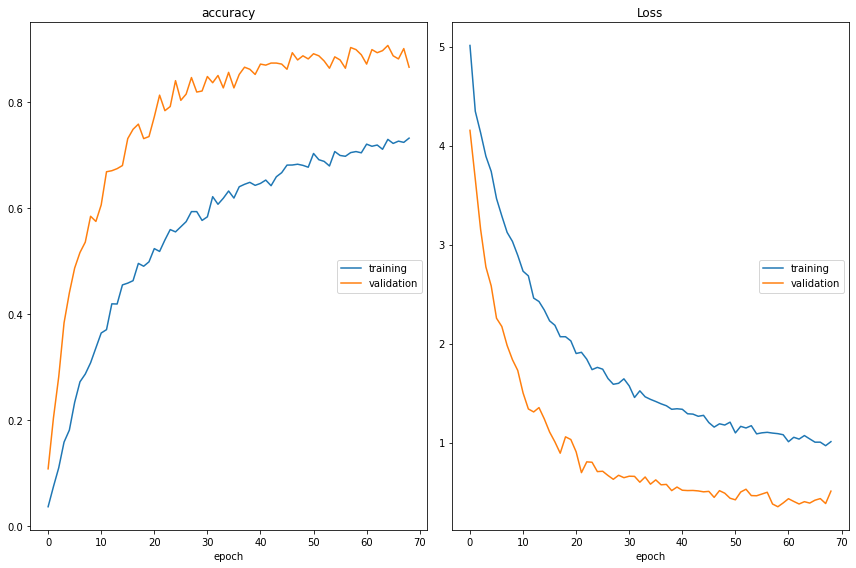

accuracy
	training         	 (min:    0.036, max:    0.731, cur:    0.731)
	validation       	 (min:    0.107, max:    0.906, cur:    0.865)
Loss
	training         	 (min:    0.968, max:    5.012, cur:    1.009)
	validation       	 (min:    0.351, max:    4.154, cur:    0.509)
94/94 [==============================] - 77s 822ms/step - loss: 1.0087 - accuracy: 0.7314 - val_loss: 0.5088 - val_accuracy: 0.8652


In [12]:
#vgg16_model.load_weights('4096-512.hdf5')
ResNet50_history = ResNet50_model.fit(traingen,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            )

In [13]:
acc = ResNet50_history.history['accuracy']
val_acc = ResNet50_history.history['val_accuracy']

loss = ResNet50_history.history['loss']
val_loss = ResNet50_history.history['val_loss']

In [14]:
np.mean(val_acc[-40:])

0.872021484375

In [15]:
np.mean(acc[-30:])

0.6926021854082743

In [16]:
testgen = test.flow_from_directory(directory="test", 
                                   target_size=(224,224), 
                                   class_mode='categorical',
                                    )

Found 1165 images belonging to 102 classes.


In [17]:
#vgg16_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights
#vgg16_model.load_weights('4096-512.hdf5')
#vgg16_model.load_weights('VGG16_re_fun.hdf5')
#vgg16_model.load_weights('VGG16_re_fun2.hdf5') #only one dense
ResNet50_model.load_weights('ResNet50_1.hdf5')


In [18]:
results = ResNet50_model.evaluate(testgen)

37/37 [==============================] - 12s 316ms/step - loss: 0.5173 - accuracy: 0.8712


# predict

In [19]:
dataset_test ="test"
test_dir = Path(dataset_test)
test_data_image = list(test_dir.glob('*/*.jpg'))

In [20]:
a_file = open("data_array.pkl", "rb")
class_names = pickle.load(a_file)

In [21]:
class_names[7]

'13'

In [22]:
a_file1 = open("data.pkl", "rb")
flower_dict = pickle.load(a_file1)

In [23]:

for img_path in test_data_image:
    img = keras.preprocessing.image.load_img( img_path, target_size=(224,224) )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = ResNet50_model.predict(img_array)
    #print("------prediction-------")
    #print(prediction)
    #print("------prediction[0]-------")
    #print(prediction[0])
    score = tf.nn.softmax(prediction[0])
    #print("------------score---------")
    index = class_names[np.argmax(score)]
    int_index = int(index)
    print(img_path, ' : ', class_names[np.argmax(score)] ,' : ',flower_dict[int_index])
    #print(class_names[np.argmax(score)], " with ", 100 * np.max(score))

test\1\image_06744.jpg  :  1  :  pink primrose
test\1\image_06755.jpg  :  1  :  pink primrose
test\1\image_06757.jpg  :  1  :  pink primrose
test\1\image_06768.jpg  :  51  :  petunia
test\1\image_06770.jpg  :  1  :  pink primrose
test\1\image_06773.jpg  :  77  :  passion flower
test\10\image_07096.jpg  :  92  :  bee balm
test\10\image_07107.jpg  :  10  :  globe thistle
test\10\image_07109.jpg  :  92  :  bee balm
test\10\image_07120.jpg  :  10  :  globe thistle
test\10\image_07122.jpg  :  10  :  globe thistle
test\10\image_08090.jpg  :  10  :  globe thistle
test\10\image_08092.jpg  :  92  :  bee balm
test\100\image_07903.jpg  :  77  :  passion flower
test\100\image_07916.jpg  :  77  :  passion flower
test\100\image_07927.jpg  :  29  :  artichoke
test\100\image_07929.jpg  :  29  :  artichoke
test\100\image_07930.jpg  :  77  :  passion flower
test\100\image_07932.jpg  :  77  :  passion flower
test\100\image_07938.jpg  :  77  :  passion flower
test\101\image_07952.jpg  :  28  :  stemless g

test\24\image_08049.jpg  :  9  :  monkshood
test\24\image_08051.jpg  :  77  :  passion flower
test\25\image_06581.jpg  :  92  :  bee balm
test\25\image_06592.jpg  :  25  :  grape hyacinth
test\25\image_06594.jpg  :  25  :  grape hyacinth
test\25\image_06605.jpg  :  92  :  bee balm
test\25\image_06607.jpg  :  101  :  trumpet creeper
test\25\image_06610.jpg  :  38  :  great masterwort
test\26\image_06497.jpg  :  3  :  canterbury bells
test\26\image_06508.jpg  :  68  :  bearded iris
test\26\image_06510.jpg  :  75  :  thorn apple
test\26\image_06521.jpg  :  9  :  monkshood
test\26\image_06523.jpg  :  9  :  monkshood
test\26\image_06526.jpg  :  9  :  monkshood
test\27\image_06860.jpg  :  77  :  passion flower
test\27\image_06871.jpg  :  9  :  monkshood
test\27\image_06873.jpg  :  27  :  prince of wales feathers
test\27\image_06884.jpg  :  22  :  pincushion flower
test\27\image_06886.jpg  :  92  :  bee balm
test\27\image_06889.jpg  :  77  :  passion flower
test\28\image_05231.jpg  :  90  :  

test\42\image_05719.jpg  :  78  :  lotus
test\42\image_05721.jpg  :  75  :  thorn apple
test\42\image_05722.jpg  :  76  :  morning glory
test\42\image_05724.jpg  :  84  :  columbine
test\42\image_05730.jpg  :  88  :  cyclamen 
test\42\image_05731.jpg  :  88  :  cyclamen 
test\42\image_05734.jpg  :  88  :  cyclamen 
test\43\image_02329.jpg  :  43  :  sword lily
test\43\image_02342.jpg  :  43  :  sword lily
test\43\image_02355.jpg  :  84  :  columbine
test\43\image_02358.jpg  :  76  :  morning glory
test\43\image_02362.jpg  :  43  :  sword lily
test\43\image_02365.jpg  :  43  :  sword lily
test\43\image_02366.jpg  :  68  :  bearded iris
test\43\image_02370.jpg  :  77  :  passion flower
test\43\image_02397.jpg  :  88  :  cyclamen 
test\43\image_02400.jpg  :  88  :  cyclamen 
test\43\image_02401.jpg  :  98  :  mexican petunia
test\43\image_02405.jpg  :  28  :  stemless gentian
test\43\image_02409.jpg  :  20  :  giant white arum lily
test\43\image_02413.jpg  :  43  :  sword lily
test\43\ima

test\53\image_03730.jpg  :  53  :  primula
test\53\image_03731.jpg  :  26  :  corn poppy
test\54\image_05409.jpg  :  77  :  passion flower
test\54\image_05422.jpg  :  77  :  passion flower
test\54\image_05433.jpg  :  77  :  passion flower
test\54\image_05435.jpg  :  77  :  passion flower
test\54\image_05436.jpg  :  77  :  passion flower
test\54\image_05438.jpg  :  77  :  passion flower
test\54\image_05444.jpg  :  77  :  passion flower
test\54\image_05445.jpg  :  77  :  passion flower
test\54\image_05458.jpg  :  77  :  passion flower
test\55\image_04709.jpg  :  55  :  pelargonium
test\55\image_04717.jpg  :  51  :  petunia
test\55\image_04735.jpg  :  88  :  cyclamen 
test\55\image_04738.jpg  :  55  :  pelargonium
test\55\image_04740.jpg  :  4  :  sweet pea
test\55\image_04742.jpg  :  55  :  pelargonium
test\55\image_04745.jpg  :  4  :  sweet pea
test\55\image_04746.jpg  :  94  :  foxglove
test\55\image_04764.jpg  :  51  :  petunia
test\55\image_04765.jpg  :  76  :  morning glory
test\56\

test\7\image_08101.jpg  :  7  :  moon orchid
test\7\image_08104.jpg  :  7  :  moon orchid
test\70\image_05288.jpg  :  77  :  passion flower
test\70\image_05301.jpg  :  70  :  tree poppy
test\70\image_05312.jpg  :  28  :  stemless gentian
test\70\image_05314.jpg  :  94  :  foxglove
test\70\image_05315.jpg  :  28  :  stemless gentian
test\70\image_05317.jpg  :  9  :  monkshood
test\70\image_05323.jpg  :  28  :  stemless gentian
test\70\image_05324.jpg  :  25  :  grape hyacinth
test\70\image_05337.jpg  :  25  :  grape hyacinth
test\71\image_04502.jpg  :  77  :  passion flower
test\71\image_04507.jpg  :  78  :  lotus
test\71\image_04520.jpg  :  77  :  passion flower
test\71\image_04523.jpg  :  77  :  passion flower
test\71\image_04527.jpg  :  41  :  barbeton daisy
test\71\image_04530.jpg  :  77  :  passion flower
test\71\image_04531.jpg  :  77  :  passion flower
test\71\image_04549.jpg  :  77  :  passion flower
test\71\image_04554.jpg  :  77  :  passion flower
test\71\image_04555.jpg  :  8

test\8\image_03323.jpg  :  8  :  bird of paradise
test\8\image_03326.jpg  :  8  :  bird of paradise
test\8\image_03330.jpg  :  8  :  bird of paradise
test\8\image_03333.jpg  :  8  :  bird of paradise
test\8\image_03334.jpg  :  8  :  bird of paradise
test\8\image_03352.jpg  :  8  :  bird of paradise
test\8\image_03357.jpg  :  8  :  bird of paradise
test\8\image_03358.jpg  :  8  :  bird of paradise
test\8\image_03363.jpg  :  8  :  bird of paradise
test\8\image_03366.jpg  :  8  :  bird of paradise
test\80\image_01985.jpg  :  76  :  morning glory
test\80\image_02003.jpg  :  80  :  anthurium
test\80\image_02006.jpg  :  9  :  monkshood
test\80\image_02010.jpg  :  77  :  passion flower
test\80\image_02013.jpg  :  67  :  spring crocus
test\80\image_02014.jpg  :  78  :  lotus
test\80\image_02032.jpg  :  19  :  balloon flower
test\80\image_02037.jpg  :  80  :  anthurium
test\80\image_02038.jpg  :  88  :  cyclamen 
test\80\image_02043.jpg  :  80  :  anthurium
test\80\image_02045.jpg  :  23  :  fr

test\90\image_04443.jpg  :  9  :  monkshood
test\90\image_04447.jpg  :  55  :  pelargonium
test\90\image_04450.jpg  :  89  :  watercress
test\90\image_04451.jpg  :  28  :  stemless gentian
test\90\image_04469.jpg  :  78  :  lotus
test\90\image_04474.jpg  :  76  :  morning glory
test\90\image_04475.jpg  :  28  :  stemless gentian
test\90\image_04480.jpg  :  82  :  clematis
test\90\image_07300.jpg  :  28  :  stemless gentian
test\91\image_04850.jpg  :  84  :  columbine
test\91\image_04855.jpg  :  3  :  canterbury bells
test\91\image_04868.jpg  :  84  :  columbine
test\91\image_04871.jpg  :  84  :  columbine
test\91\image_04875.jpg  :  9  :  monkshood
test\91\image_04878.jpg  :  76  :  morning glory
test\91\image_04879.jpg  :  77  :  passion flower
test\91\image_08054.jpg  :  9  :  monkshood
test\91\image_08055.jpg  :  9  :  monkshood
test\91\image_08059.jpg  :  76  :  morning glory
test\91\image_08060.jpg  :  84  :  columbine
test\92\image_03048.jpg  :  38  :  great masterwort
test\92\im

# Summary 

# DATA SET 1

# renest50 - without finite



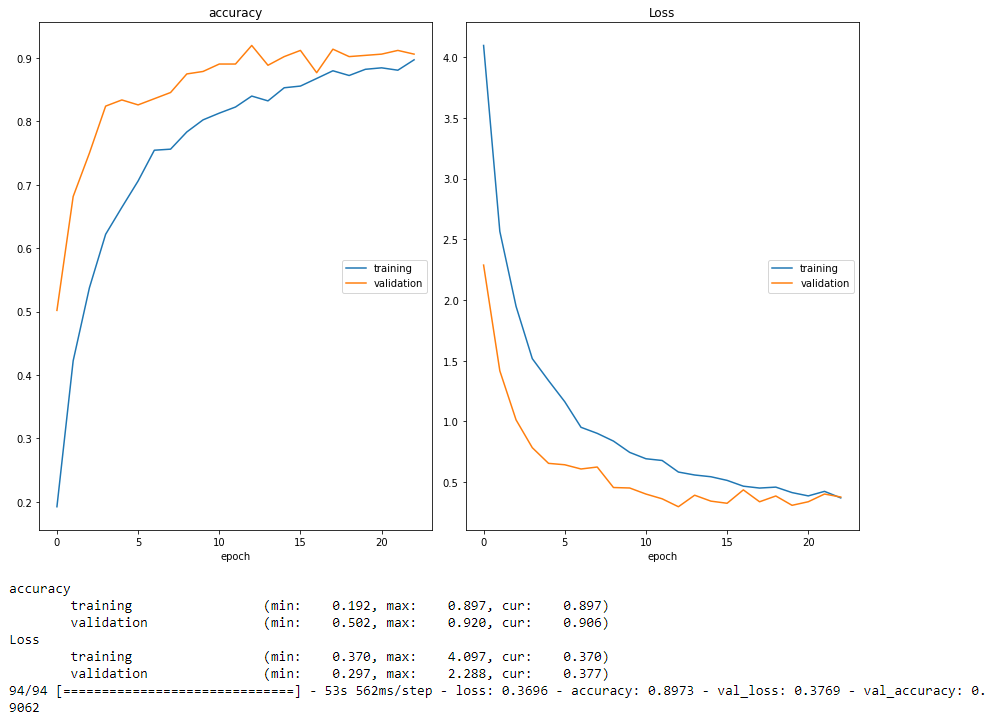

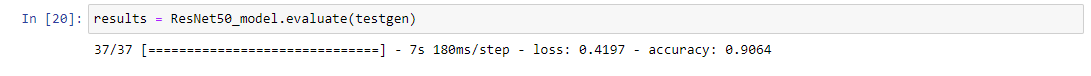

# renest50 - 4 layers finite

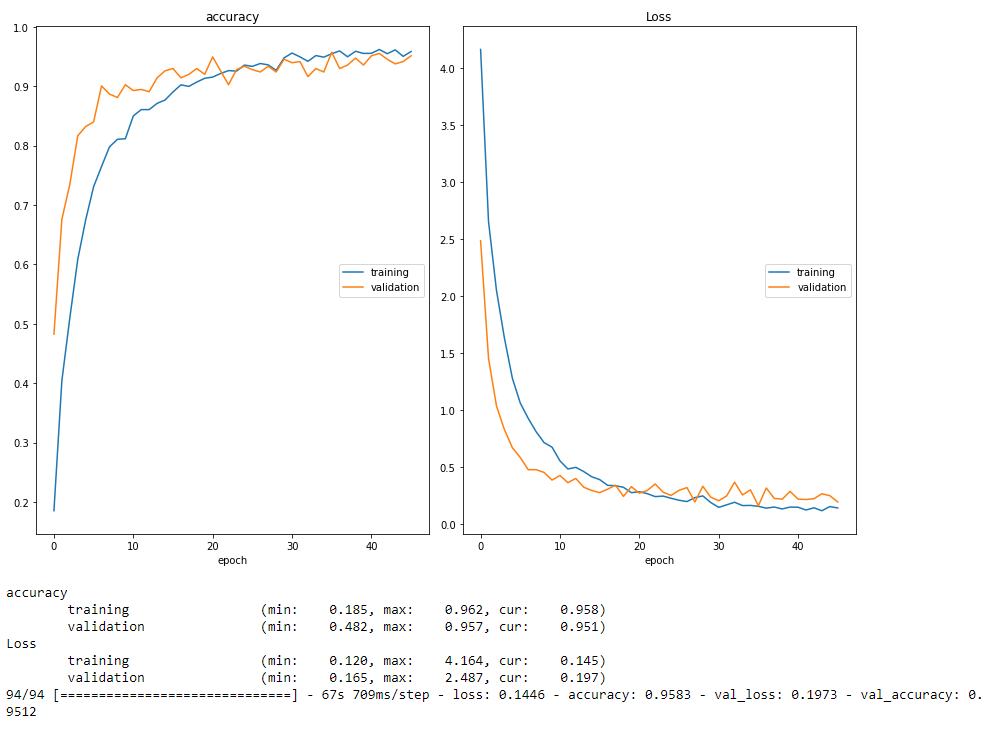

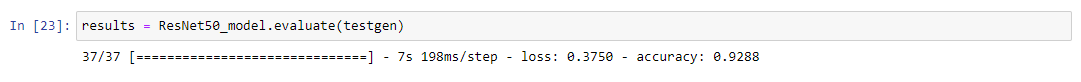

# DATA SET 2


# no fine tunning
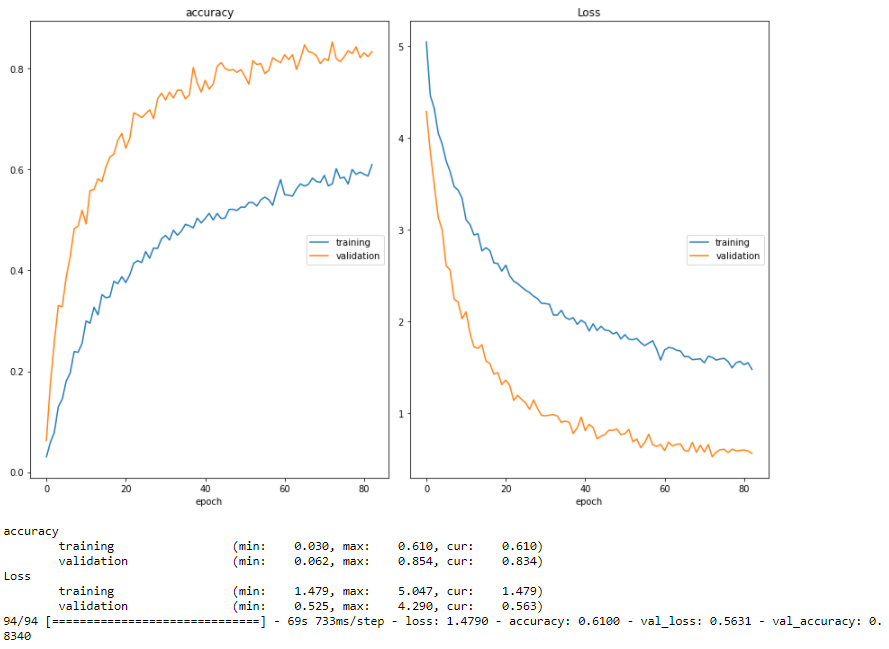

# Fine tunning
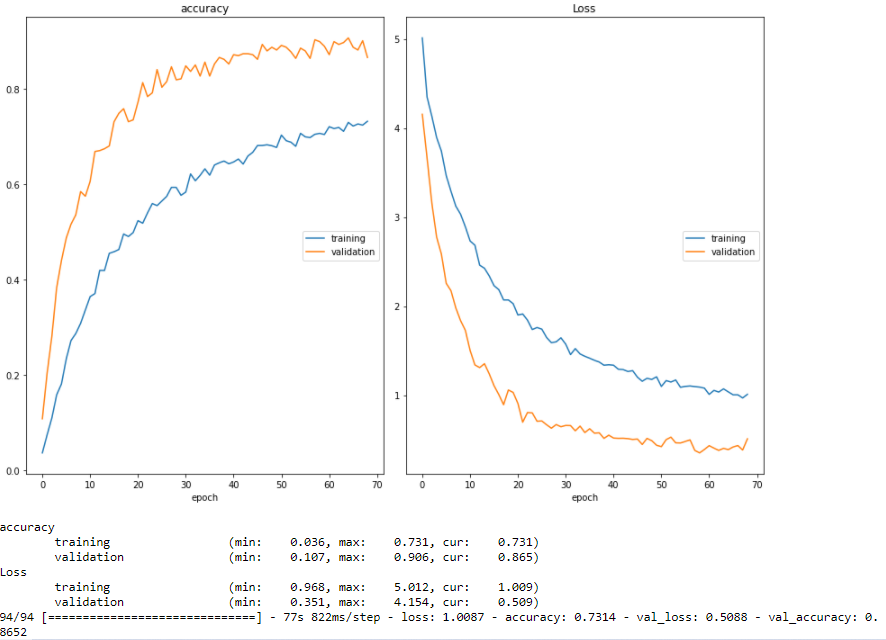